In [2]:
import numpy as np
import os
import pandas as pd
import pickle
from scipy.io import loadmat

In [3]:
os.getcwd()

'/UbuntuHDD/Social-Rec-Sys/Transformer_modified'

In [4]:
os.listdir(os.getcwd() + '/dataset/')

['ciao_DGNN', 'ciao', 'toy']

## [DGNN](https://github.com/HKUDS/DGNN)'s processed data

In [5]:
path_dir = os.getcwd() + '/dataset/ciao_DGNN/dataset.pkl'
with open(path_dir, 'rb') as f:
    dataset = pickle.load(f)
dataset

/tmp/ipykernel_198650/177037630.py:3: DeprecationWarning: Please use `coo_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.coo` namespace is deprecated.
  dataset = pickle.load(f)


{'userCount': 1925,
 'itemCount': 15053,
 'categoryCount': 6,
 'train': <1925x15053 sparse matrix of type '<class 'numpy.int32'>'
 	with 30370 stored elements in COOrdinate format>,
 'val': <1925x15053 sparse matrix of type '<class 'numpy.int32'>'
 	with 1242 stored elements in COOrdinate format>,
 'test': <1925x15053 sparse matrix of type '<class 'numpy.int32'>'
 	with 1563 stored elements in COOrdinate format>,
 'category': <15053x6 sparse matrix of type '<class 'numpy.int32'>'
 	with 15056 stored elements in COOrdinate format>,
 'trust': <1925x1925 sparse matrix of type '<class 'numpy.int32'>'
 	with 65084 stored elements in COOrdinate format>}

- COO format $\rightarrow$ DataFrame

In [6]:
# 각 item의 category를 one-hot으로 표현
# shape: (itemId, categoryId) 
data_category = pd.DataFrame.sparse.from_spmatrix(dataset['category'])
data_category

,0,1,2,3,4,5
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
15048,0,1,0,0,0,0
15049,1,0,0,0,0,0
15050,1,0,0,0,0,0
15051,1,0,0,0,0,0


In [7]:
data_category.astype(bool).sum(axis=0)

0    1874
1    2506
2    1985
3    1444
4    3654
5    3593
dtype: int64

In [8]:
# 사용자 간의 연결 정도를 표현: social graph
# shape: (userId, userId)
data_trust = pd.DataFrame.sparse.from_spmatrix(dataset['trust'])
data_trust

,0,1,2,3,4,5,6,7,8,9,...,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- GraphRec에서 보고한 Ciao information과 DGNN에서 보고한 Ciao information이 다름. 
- 원본 dataset을 서로 다르게 가공하느라 발생한것인지?
  - https://arxiv.org/pdf/1905.07854.pdf & https://arxiv.org/pdf/1904.12796.pdf 을 따랐다고 설명
  - 상호작용이 10개 미만인 사용자는 drop & missing category(description)인 데이터도 drop
  $\rightarrow$ 그래서 원본 Ciao랑 갯수 차이가 크게 나는듯.

In [9]:
# 각각이 모두 user-item matrix. 
# DGNN은 ranking으로 접근 -> negative sample(상호작용하지 않은 아이템)을 val, test에 추가해서 사용
data_train = pd.DataFrame.sparse.from_spmatrix(dataset['train'])
data_val = pd.DataFrame.sparse.from_spmatrix(dataset['val'])
data_test = pd.DataFrame.sparse.from_spmatrix(dataset['test'])

In [10]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,15043,15044,15045,15046,15047,15048,15049,15050,15051,15052
0,0,0,5,5,5,4,5,4,5,4,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,0,0,0,0,0,0,0,0,...,5,5,5,2,5,4,0,0,0,0
1922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,4,3,4
1923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
data_val

,0,1,2,3,4,5,6,7,8,9,...,15043,15044,15045,15046,15047,15048,15049,15050,15051,15052
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,15043,15044,15045,15046,15047,15048,15049,15050,15051,15052
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1922,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1923,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Raw data

In [13]:
path_dir = os.getcwd() + '/dataset/ciao/'
rating_file = loadmat(path_dir + 'rating.mat')
trust_file = loadmat(path_dir + 'trustnetwork.mat')

# rating.mat includes the rating information. there are five columns and they are userid, productid, categoryid, rating, helpfulness, respectively. 
rating_data = rating_file['rating'].astype(np.int64)

# trustnetwork.mat includes the trust relations between users. There are two columns and both of them are userid.
trust_data = trust_file['trustnetwork'].astype(np.int64)

In [14]:
rating_data, trust_data

(array([[     1,      1,      1,      3,      1],
        [     1,      2,      1,      4,      1],
        [     1,      3,      2,      4,      1],
        ...,
        [  7375,  72772,     24,      4,      2],
        [  7375,  74985,     24,      5,      1],
        [  7375, 101247,     24,      1,      4]]),
 array([[   1,    2],
        [   1,    3],
        [   1,    4],
        ...,
        [7374, 7373],
        [7374, 7369],
        [7375, 5285]]))

In [15]:
rating_data = pd.DataFrame(rating_data, columns=['user_id', 'product_id', 'category_id', 'rating', 'helpfulness'])
trust_data = pd.DataFrame(trust_data, columns=['user_id1', 'user_id2'])

In [16]:
rating_data

,user_id,product_id,category_id,rating,helpfulness
0,1,1,1,3,1
1,1,2,1,4,1
2,1,3,2,4,1
3,1,4,1,5,1
4,1,5,1,4,1
...,...,...,...,...,...
284081,7375,73419,8,1,2
284082,7375,25291,24,3,1
284083,7375,72772,24,4,2
284084,7375,74985,24,5,1


In [17]:
trust_data

,user_id1,user_id2
0,1,2
1,1,3
2,1,4
3,1,5
4,1,6
...,...,...
111776,7373,7374
111777,7373,7369
111778,7374,7373
111779,7374,7369


In [18]:
rating_data['user_id'].nunique(), rating_data['product_id'].nunique(), rating_data['rating'].nunique()

(7375, 105114, 6)

In [19]:
rating_data['rating'].value_counts(), rating_data['helpfulness'].value_counts()

(rating
 5    138893
 4     88499
 3     31294
 2     14317
 1     11049
 0        34
 Name: count, dtype: int64,
 helpfulness
 1    198173
 2     70450
 4     11409
 3      2464
 6      1199
 5       377
 7        14
 Name: count, dtype: int64)

- 7,375 user, 105,114 items, 6 ratings (0 ~ 5), 7 helpfulness (1 ~ 7)
  - helpfulness는 해당 평점에 대한 도움이 되었어요 와 같은 지표를 의미.

### rating_data $\rightarrow$ user-item matrix

In [20]:
user_item_matrix = rating_data.pivot_table(
    values = 'rating',
    index = 'user_id',
    columns = 'product_id'
).fillna(0)
user_item_matrix

product_id,1,2,3,4,5,6,7,8,9,10,...,106787,106788,106789,106790,106791,106792,106794,106795,106796,106797
user_id,,,,,,,,,,,,,,,,,,,,,
1,3.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0
7372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
user_item_matrix.loc[1].values # user_id 1이 평점을 매긴 아이템 목록

array([3., 4., 4., ..., 0., 0., 0.])

In [22]:
# Sparsity check?
1.0 - (np.count_nonzero(user_item_matrix.to_numpy()) / float(user_item_matrix.to_numpy().size))

0.9996354318136597

### trust_data $\rightarrow$ user-user matrix(social graph)

In [25]:
# user_user_matrix = trust_data.pivot_table(
#     values = 1,
#     index = 'user_id',
#     columns = 'user_id'
# ).fillna(0)
# user_user_matrix

import networkx as nx

user_user_matrix = nx.from_pandas_edgelist(trust_data, source='user_id1', target='user_id2')
user_user_matrix = nx.to_pandas_adjacency(user_user_matrix)
user_user_matrix

,1,2,3,4,5,6,7,8,9,10,...,7352,7355,7358,7361,7371,7372,7369,7373,7374,7375
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
7373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


=============== Each Node's Degree ===============
      node  degree
0        1     128
1        2      25
2        3      36
3        4     132
4        5      67
...    ...     ...
7312  7372       1
7313  7369       5
7314  7373       2
7315  7374       2
7316  7375       2

[7317 rows x 2 columns]
      node  degree
764    766     804
986    988     757
272    273     646
572    575     644
738    740     641
...    ...     ...
6700  6731       1
6701  6732       1
6702  6733       1
6703  6734       1
6755  6792       1

[7317 rows x 2 columns]
=============== Degree less than 10 ===============
      node  degree
25      26       4
32      33       9
47      48       4
52      53       9
53      54       3
...    ...     ...
7312  7372       1
7313  7369       5
7314  7373       2
7315  7374       2
7316  7375       2

[4209 rows x 2 columns]
=============== Degree statistics ===============
count    7317.000000
mean       23.289600
std        44.644794
min         1.000000
25% 

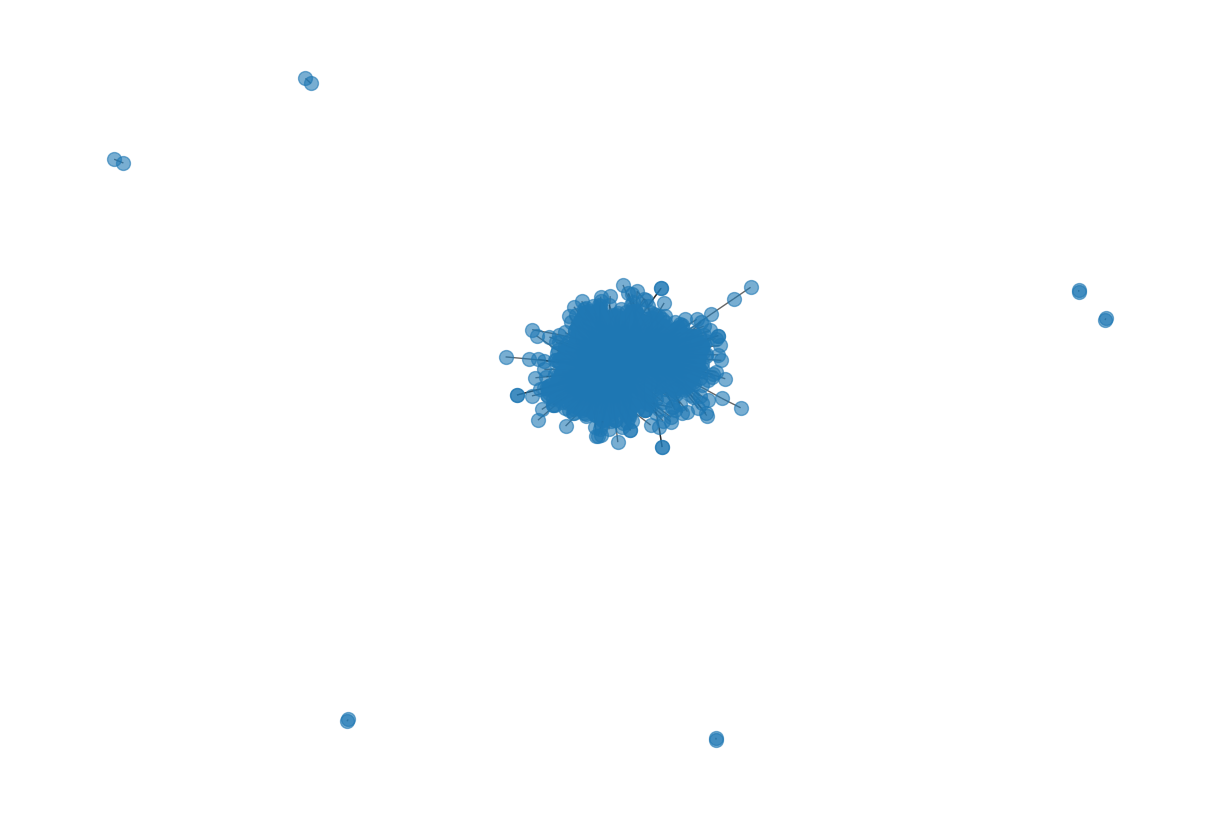

In [92]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 8))
graph = nx.from_pandas_edgelist(trust_data, source='user_id1', target='user_id2')

# degrees = [val for (node, val) in graph.degree()]
degrees = {node: val for (node, val) in graph.degree()}
degree_df = pd.DataFrame(degrees.items(), columns=['node', 'degree'])

print("="*15, "Each Node's Degree", "="*15)
print(degree_df)
print(degree_df.sort_values(by='degree', ascending=False))

# degree 10 이하인 user가 4209
print("="*15, "Degree less than 10", "="*15)
print(degree_df.loc[degree_df['degree'] <= 10])

print("="*15, "Degree statistics", "="*15)
print(degree_df['degree'].describe())

# graph view?
nx.draw(graph, pos=nx.spring_layout(graph), node_size=100, alpha=0.6)
plt.show()

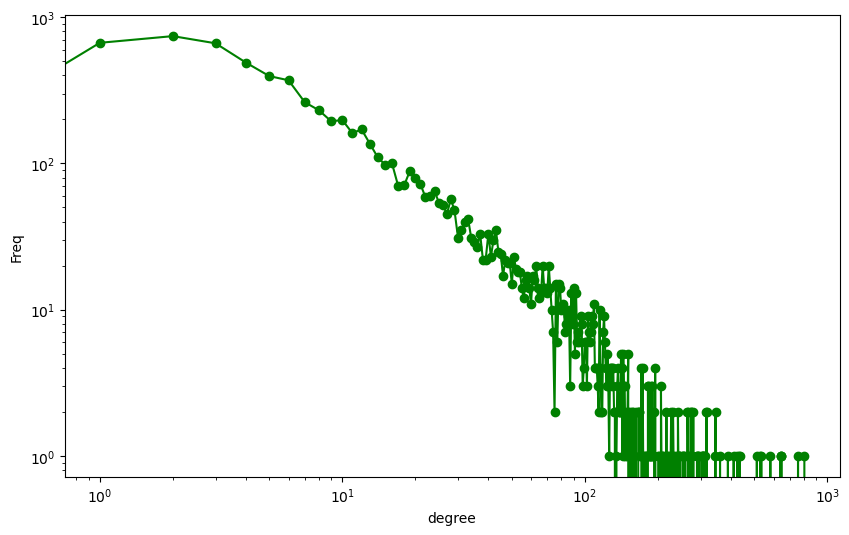

In [91]:
# degree chart -> 역시 power-law graph.
degree_freq = nx.degree_histogram(graph)
degree_list = range(len(degree_freq))

plt.figure(figsize=(10, 6))
plt.loglog(degree_list, degree_freq, 'go-')
plt.xlabel('degree')
plt.ylabel('Freq')
plt.show()

### Simple preprocess, following Graphormer's preprocess

In [28]:
import torch

# Adj matrix 형태로 변환
adj = torch.from_numpy(user_user_matrix.values)

# compute degree: 각 user node마다의 degree 정보가 담긴 tensor 생성
degree = adj.long().sum(dim=1).view(-1)
degree, degree.shape

(tensor([128,  25,  36,  ...,   2,   2,   2]), torch.Size([7317]))

In [29]:
# Cython import
import sys
import pyximport

pyximport.install(setup_args={"include_dirs": np.get_include()})

# os.getcwd()
import algos

In [30]:
# about 3m 30s in raw Ciao's trustnetwork
    # float64 type을 다른 형식으로 미리 하지 않으면 algos에서 지정한 casting error (line15: .astype(long, order='C', casting='safe', copy=True))
shortest_path_result, path = algos.floyd_warshall(adj.numpy().astype(np.int64))

In [34]:
print(shortest_path_result)
print(shortest_path_result.shape)

[[0 1 1 ... 6 6 4]
 [1 0 1 ... 6 6 4]
 [1 1 0 ... 6 6 5]
 ...
 [6 6 6 ... 0 1 2]
 [6 6 6 ... 1 0 2]
 [4 4 5 ... 2 2 0]]
(7317, 7317)


In [35]:
print(path)
print(path.shape)

[[  -1   -1   -1 ... 7313 7313 5278]
 [  -1   -1   -1 ... 7313 7313 5278]
 [  -1   -1   -1 ... 7313 7313 5278]
 ...
 [7313 7313 7313 ...   -1   -1 7313]
 [7313 7313 7313 ...   -1   -1 7313]
 [5278 5278 5278 ... 7313 7313   -1]]
(7317, 7317)


In [39]:
max_dist = np.amax(shortest_path_result)
max_dist

510

In [41]:
# 각 노드별로 거리에 따른 spatial positional encoding에 활용할 정보
spatial_pos = torch.from_numpy((shortest_path_result)).long()
print(spatial_pos)
print(spatial_pos.shape)

tensor([[0, 1, 1,  ..., 6, 6, 4],
        [1, 0, 1,  ..., 6, 6, 4],
        [1, 1, 0,  ..., 6, 6, 5],
        ...,
        [6, 6, 6,  ..., 0, 1, 2],
        [6, 6, 6,  ..., 1, 0, 2],
        [4, 4, 5,  ..., 2, 2, 0]])
torch.Size([7317, 7317])
